## 할당할 GPU 번호 지정

In [1]:
import os, torch

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['NVIDIA_VISIBLE_DEVICES'] = "0"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


## CRAFT 모델 utils & network

In [4]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
from text_detection import craft_utils
from text_detection import imgproc
import text_detection.file_utils
import json
import zipfile

from text_detection.craft import CRAFT

from collections import OrderedDict

import matplotlib.pyplot as plt

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly,refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.to(device)

    # forward pass
    with torch.no_grad():
        y, feature = net(x)
    
    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()


    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    
    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)
    
    if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text

In [5]:
class Args():
    def __init__(self,cuda=False, trained_model='weights/craft_mlt_25k.pth', text_threshold=0.7, low_text=0.4, link_threshold=0.4, canvas_size =1280, mag_ratio=1.5, poly=False, show_time=False,test_folder='/data/',refine=False, refiner_model='weights/craft_refiner_CTW1500.pth'):
        self.cuda = cuda
        self.trained_model = trained_model = trained_model
        self.text_threshold = text_threshold
        self.low_text = low_text
        self.link_threshold = link_threshold
        self.canvas_size = canvas_size
        self.mag_ratio = mag_ratio
        self.poly = poly
        self.show_time = show_time
        self.test_folder = test_folder
        self.refine = refine
        self.refiner_model = refiner_model
        
        
def img_show(img, size =(15,15)):
    plt.rcParams["figure.figsize"] = size
    imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
import os
    
args = Args(test_folder='./',text_threshold=0.8,link_threshold=0.4,canvas_size=1800,refine=False,poly=False,cuda=True)

## CRAFT weight file load & net evaluation

In [7]:
regist_img_num = 0
# test_img_num = 1

# load net
net = CRAFT()     # initialize

print('Loading weights from checkpoint (' + args.trained_model + ')')
# device=torch.device('cuda')

net.load_state_dict(copyStateDict(torch.load(args.trained_model,map_location="cuda")))
print(device)

net = net.to(device)
cudnn.benchmark = True

net.eval()

craft_memory = torch.cuda.memory_allocated()/1024/1024

print("torch.cuda.memory_allocated: %fMB"%(craft_memory))

Loading weights from checkpoint (weights/craft_mlt_25k.pth)
cuda
torch.cuda.memory_allocated: 81.041504MB


In [8]:
net

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

## refine net

In [8]:
print("current_memory:", craft_memory)

# LinkRefiner
from refinenet import RefineNet
refine_net = RefineNet()
print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')

print("torch.cuda.memory_allocated: %fMB"%(torch.cuda.memory_allocated()/1024/1024))
if args.cuda:
    refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model,map_location="cuda")))
#     refine_net.load_state_dict(torch.load(args.refiner_model))
    refine_net = refine_net.to(device)
    print(device)
#     refine_net = torch.nn.DataParallel(refine_net)
else:
    refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

refine_net.eval()
args.poly = True

refine_memory = torch.cuda.memory_allocated()/1024/1024
print("after_memory:", refine_memory)
print("torch.cuda.memory_allocated: %fMB"%(refine_memory - craft_memory))

current_memory: 81.04150390625
Loading weights of refiner from checkpoint (weights/craft_refiner_CTW1500.pth)
torch.cuda.memory_allocated: 81.041504MB
cuda
after_memory: 82.80859375
torch.cuda.memory_allocated: 1.767090MB


## CRAFT weight file load 및 들어올 이미지 shape 과 동일한 input 값 지정

In [10]:
from PIL import Image
from torchvision import transforms

# img = Image.open("201904291390027161_3.jpeg").convert('RGB')

# # resize = transforms.Resize([224, 224])
# # img = resize(img)

# # img_y = img.convert('RGB')
# # # img_y, img_cb, img_cr = img_ycbcr.split()

# # to_tensor = transforms.ToTensor()
# # img_y = to_tensor(img_y)
# # img_y
# img = np.array(img)
# img.shape

In [ ]:
x = np.ones(shape=(1200,1200,3),dtype=np.uint8)
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(x, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
# ratio_h = ratio_w = 1 / target_ratio

# preprocessing
x = imgproc.normalizeMeanVariance(img_resized)

x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
x = x.to(device)

## torch2trt API

In [8]:
import torch
from torch2trt import torch2trt

craft_model = CRAFT()
craft_model.load_state_dict(copyStateDict(torch.load(args.trained_model,map_location="cuda")))
craft_model.to(device)
# craft_model = torch.nn.DataParallel(craft_model)
craft_model.eval()

model_trt = torch2trt(craft_model, [x])

In [9]:
torch.save(model_trt.state_dict(), 'craft_trt.pth')

## TRTModule 함수를 불러와서 저장한 torch2trt pth 파일 로드


In [12]:
print("current_memory:", refine_memory)

from torch2trt import TRTModule

model_trt = TRTModule()

model_trt.load_state_dict(torch.load('craft_trt.pth'))

model_trt.to(device)
craft_trt_memory = torch.cuda.memory_allocated()/1024/1024
print("after_memory:", craft_trt_memory)
print("torch.cuda.memory_allocated: %fMB"%(craft_trt_memory - refine_memory))


current_memory: 82.80859375
after_memory: 109.52734375
torch.cuda.memory_allocated: 26.718750MB


In [11]:
image_path = "test_sa2.jpeg"
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(img, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
ratio_h = ratio_w = 1 / target_ratio

# preprocessing
img_prp = imgproc.normalizeMeanVariance(img_resized)

img_prp = torch.from_numpy(img_prp).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
img_prp = Variable(img_prp.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
img_prp = img_prp.to(device)
img_prp.shape

torch.Size([1, 3, 1824, 1280])

In [14]:
t = time.time()
print("current_memory:", refinenet_trt_memory)
y, feature = net(img_prp)
t_net  = time.time() - t
print('net time:', t_net)
net_trt_memory = torch.cuda.memory_allocated()/1024/1024
print("after_memory:", net_trt_memory)
print("torch.cuda.memory_allocated: %fMB"%(net_trt_memory - refinenet_trt_memory))

t = time.time()
print()
print("current_memory:", net_trt_memory)
y_trt, feature_trt = model_trt(img_prp)
t_trt  = time.time() - t
print('trt time:', t_trt)
t_trt_memory = torch.cuda.memory_allocated()/1024/1024
print("after_memory:", t_trt_memory)
print("torch.cuda.memory_allocated: %fMB"%(t_trt_memory - net_trt_memory))

current_memory: 109.52734375
net time: 3.7424910068511963
after_memory: 7621.94921875
torch.cuda.memory_allocated: 7512.421875MB

current_memory: 7621.94921875
trt time: 0.039560794830322266
after_memory: 7703.330078125
torch.cuda.memory_allocated: 81.380859MB


## CRAFT 와 CRAFT2trt의 output 크기가 다름

In [19]:
y.shape

torch.Size([1, 912, 640, 2])

In [20]:
y_trt.shape

torch.Size([1, 912, 688, 2])

## 아래 시각화 결과를 통해 TRT 모델이 inference를 아예 못하는 것을 확인 할 수 있음

### 이를 통해 torch2trt의 기본적인 방법대로 진행하는 것은 잘못되었다고 판단

In [15]:
# make score and link map
print("current_memory:", t_trt_memory)
t = time.time()
score_text = y[0,:,:,0].cpu().detach().numpy()
score_link = y[0,:,:,1].cpu().detach().numpy()

# refine link
with torch.no_grad():
    y_refiner = refine_net(y, feature)
score_link = y_refiner[0,:,:,0].cpu().detach().numpy()

t_net  = time.time() - t
print('net time:', t_net)

refine_net_memory = torch.cuda.memory_allocated()/1024/1024
print("after_memory:", refine_net_memory)
print("torch.cuda.memory_allocated: %fMB"%(refine_net_memory - t_trt_memory))

current_memory: 7703.330078125
net time: 0.7799158096313477
after_memory: 7705.556640625
torch.cuda.memory_allocated: 2.226562MB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


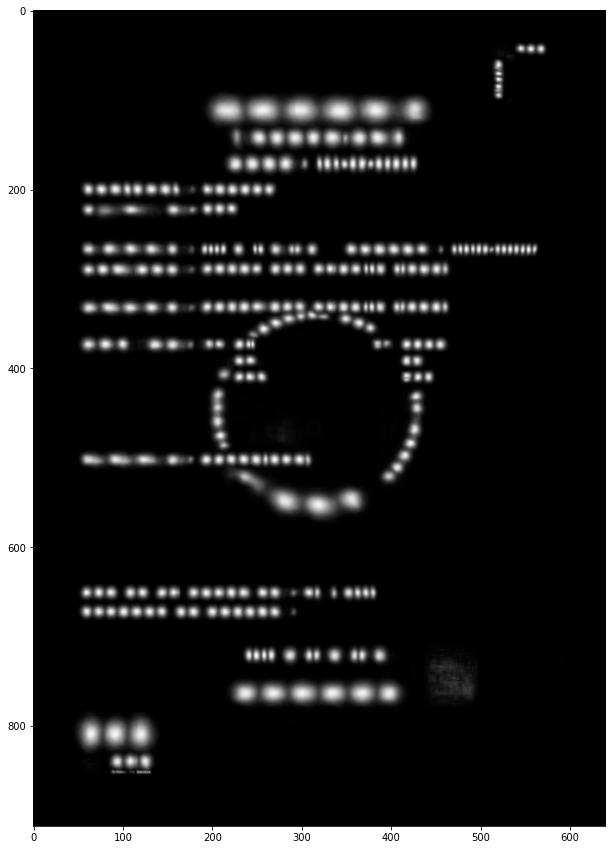

In [16]:
img_show(score_text)

In [17]:
print("current_memory:", refine_net_memory)
t_2 = time.time()
score_text_trt = y_trt[0,:,:,0].detach().cpu().numpy()
score_link_trt = y_trt[0,:,:,1].detach().cpu().numpy()

# refine link
with torch.no_grad():
    y_refiner_trt = refine_model_trt(y_trt, feature_trt)
score_link_trt = y_refiner_trt[0,:,:,0].detach().cpu().numpy()

t_trt  = time.time() - t_2
print('trt time:', t_trt)
trt_memory = torch.cuda.memory_allocated()/1024/1024
print("after_memory:", trt_memory)
print("torch.cuda.memory_allocated: %fMB"%(trt_memory - refine_net_memory))

current_memory: 7705.556640625
trt time: 0.04706525802612305
after_memory: 7707.9501953125
torch.cuda.memory_allocated: 2.393555MB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


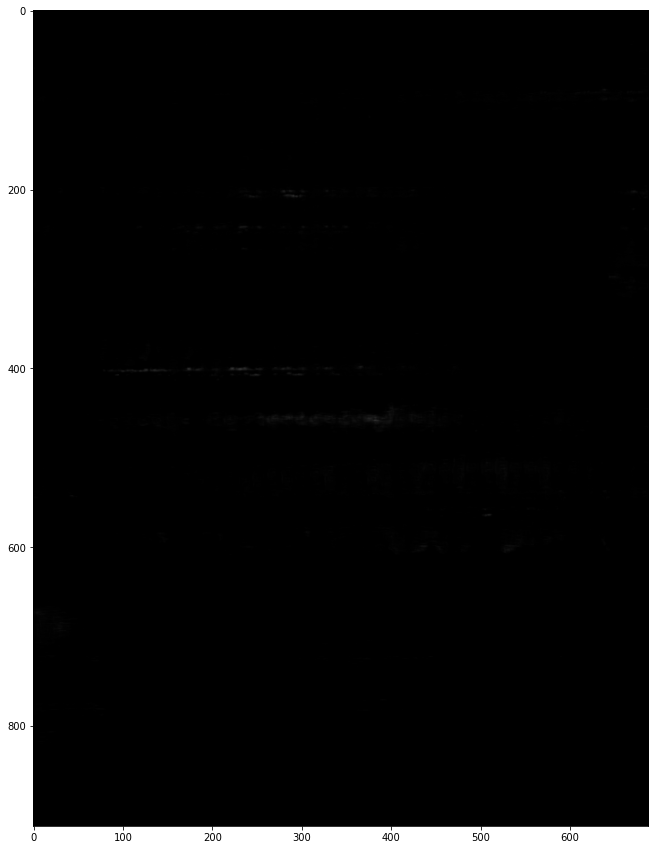

In [22]:
img_show(score_text_trt)